Created by Joan-Marc Fisa

- Numerai: [FisaGol](https://numer.ai/fisagol)

- Twitter: [@fisagol](https://twitter.com/fisagol)


In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep 11 17:18:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!pip install numerapi

In [4]:

!pip install vecstack;

  Created wheel for vecstack: filename=vecstack-0.4.0-py3-none-any.whl size=19878 sha256=643207dcaa6bcc68af6e4c28de8dfe0dfb35a7c76b120134d3d1448e78d7399a
  Stored in directory: /root/.cache/pip/wheels/28/fe/0c/fe8e43660e3316d7ce204e59a79a72246c0ae9b6c5c79841c8
Successfully built vecstack


In [5]:
!pip install halo

  Created wheel for halo: filename=halo-0.0.31-py3-none-any.whl size=11260 sha256=9e89a871daf445994c9bcb050a47dd696b8212bce41be1e590301cc87d26c59d
  Stored in directory: /root/.cache/pip/wheels/95/ff/20/5d16a0059f20c5e60be2df845201e73af179a5a79a3d566f48
Successfully built halo


In [6]:
import os
import gc
import pathlib
import numpy as np
import pandas as pd
import scipy.stats
import tensorflow as tf
import joblib
from tqdm.notebook import tqdm
from numerapi import NumerAPI
from halo import Halo
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [7]:
napi = NumerAPI()
spinner = Halo(text='', spinner='dots')

In [8]:
current_round = napi.get_current_round(tournament=8)

In [9]:
napi.download_dataset("numerai_tournament_data.parquet", f"numerai_tournament_data_{current_round}.parquet")
napi.download_dataset("example_predictions.parquet", f"example_predictions_{current_round}.parquet")

2021-09-11 17:18:46,228 INFO numerapi.utils: starting download
numerai_tournament_data_280.parquet:  99%|█████████▉| 578M/582M [00:14<00:00, 41.0MB/s]2021-09-11 17:19:01,676 INFO numerapi.utils: starting download

example_predictions_280.parquet:   0%|          | 0.00/33.5M [00:00<?, ?B/s]
example_predictions_280.parquet:   0%|          | 74.8k/33.5M [00:00<01:01, 542kB/s]
example_predictions_280.parquet:   2%|▏         | 589k/33.5M [00:00<00:11, 2.88MB/s]
example_predictions_280.parquet:   6%|▌         | 2.08M/33.5M [00:00<00:03, 7.95MB/s]
example_predictions_280.parquet:  18%|█▊        | 5.87M/33.5M [00:00<00:01, 19.2MB/s]
example_predictions_280.parquet:  28%|██▊       | 9.48M/33.5M [00:00<00:00, 25.1MB/s]
example_predictions_280.parquet:  41%|████▏     | 13.8M/33.5M [00:00<00:00, 31.2MB/s]
example_predictions_280.parquet:  54%|█████▍    | 18.1M/33.5M [00:00<00:00, 35.0MB/s]
example_predictions_280.parquet:  67%|██████▋   | 22.4M/33.5M [00:00<00:00, 37.6MB/s]
example_predictions_280

In [10]:
tournament_data = pd.read_parquet(f'numerai_tournament_data_{current_round}.parquet')

numerai_tournament_data_280.parquet: 582MB [00:16, 34.8MB/s]                           
example_predictions_280.parquet: 33.5MB [00:01, 26.0MB/s]                            


In [11]:
example_preds = pd.read_parquet(f'example_predictions_{current_round}.parquet')

In [12]:
feature_cols = [c for c in tournament_data if c.startswith("feature_")]
print(len(feature_cols))

1050


In [13]:
targets = [c for c in tournament_data if c.startswith("target")]

In [14]:
X = tournament_data[feature_cols]

In [16]:
pca = PCA(n_components=310)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=310, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [17]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.091504   0.16289317 0.21134487 0.25382285 0.28778588 0.31297746
 0.33525962 0.3549054  0.37234771 0.3897392  0.40601992 0.41946985
 0.43196808 0.44314913 0.45385197 0.46372717 0.47314331 0.48234036
 0.49142145 0.5002902  0.50879016 0.51716543 0.52538562 0.53339643
 0.54107722 0.54854982 0.55585674 0.56295122 0.56991271 0.57647469
 0.58294407 0.58905165 0.59494701 0.60081049 0.60655425 0.61215751
 0.61773155 0.62311127 0.62836961 0.63355288 0.63861953 0.64357666
 0.64840283 0.6531886  0.65792471 0.66246134 0.6669221  0.67137472
 0.6757221  0.67996453 0.68418866 0.68829571 0.69236758 0.69640324
 0.70037813 0.70432221 0.70813174 0.71191187 0.7156645  0.71936507
 0.72304085 0.72667951 0.73026454 0.73384333 0.73730807 0.7407364
 0.74414465 0.74748222 0.75073449 0.75393125 0.75708399 0.76016364
 0.76323487 0.76627657 0.76926361 0.77222025 0.7751491  0.77796699
 0.78075599 0.78350729 0.7862474  0.78895559 0.79163236 0.79429199
 0.79691404 0.79948147 0.80201433 0.80451282 0.80698726 0.80942

In [18]:
pca.explained_variance_ratio_.sum()

0.9638626098494988

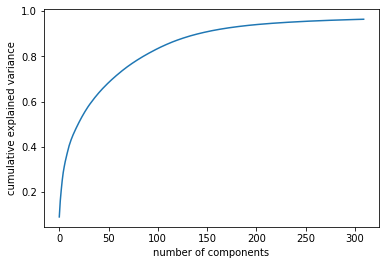

In [19]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [20]:
X_pca = pca.transform(X)

In [21]:
df_tournament = pd.DataFrame(X_pca, columns=[feature_cols[0:310]])

In [22]:
df_tournament

,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,feature_unscheduled_malignant_shingling,feature_clawed_unwept_adaptability,feature_rubblier_chlorotic_stogy,feature_untumbled_histologic_inion,feature_piffling_inflamed_jupiter,feature_abstersive_emotional_misinterpreter,feature_unluckiest_mulley_benzyl,feature_escutcheoned_timocratic_kotwal,feature_integrated_extroversive_ambivalence,feature_vedic_mitral_swiz,feature_reclaimed_fallibilist_turpentine,feature_gone_honduran_worshipper,feature_insociable_exultant_tatum,feature_outdated_tapered_speciation,feature_leggiest_slaggiest_inez,feature_chaldean_vixenly_propylite,feature_hysteric_mechanized_recklinghausen,feature_glare_factional_assessment,feature_highland_eocene_berean,feature_seemlier_reorient_monandry,feature_expressed_abhominable_pruning,feature_castrated_presented_quizzer,feature_restricted_aggregately_workmanship,feature_scorbutic_intellectualism_mongoloid,feature_telephonic_shakable_bollock,feature_subglobular_unsalable_patzer,feature_syrian_coital_counterproof,feature_supergene_legible_antarthritic,feature_hypothetic_distressing_endemic,feature_torturesome_estimable_preferrer,feature_greedier_favorable_enthymeme,feature_decent_solo_stickup,...,feature_socialized_obconical_itemization,feature_amphictyonic_secretarial_induline,feature_unsatisfied_mesopotamian_woodruff,feature_backswept_cryptogenic_baku,feature_healthiest_glial_cliquism,feature_absent_herpetological_genitor,feature_accountable_ethnographic_counterexample,feature_unseparable_cedarn_orcadian,feature_inhabited_collectable_soda,feature_arizonan_endurable_daw,feature_tanagrine_balconied_shut,feature_powdered_incased_project,feature_unassimilated_waxed_vesicle,feature_conjunctional_maned_banian,feature_contorted_weaponed_piaffe,feature_leadiest_unliveable_macadamia,feature_ignored_splay_management,feature_aggrieved_rammish_tommy,feature_coelomate_orbiculate_osteology,feature_amoebic_scarabaeid_gypsum,feature_unforbidden_flaming_settlement,feature_edge_hanoverian_cockneyfication,feature_picked_inferrible_lanark,feature_geographical_ecstatic_geta,feature_gymnastic_neap_thoracostomy,feature_nonclinical_stewed_disreputability,feature_tensed_cinnamonic_league,feature_pongid_agentive_rhomboid,feature_alloyed_copyright_protium,feature_afloat_brickiest_supernationalism,feature_healthful_mitigated_magnesium,feature_hypertrophied_embryologic_forfeiter,feature_few_lagoonal_alcyonarian,feature_temporary_dreamful_aldershot,feature_midnightly_falser_replacement,feature_nomothetic_autistic_ilk,feature_tyrian_wretched_frangipane,feature_waxiest_orthogonal_hiroshima,feature_raglan_gouty_twiddler,feature_cleanly_kickable_miriam
0,3.008633,-4.557196,-2.130866,4.292634,-3.800029,1.508002,3.023911,-1.170182,-2.086976,0.772585,0.278267,2.287162,-1.322303,-1.327879,-1.801672,0.616566,0.790324,-0.098564,-0.206797,-0.466171,0.609379,-1.726769,0.138129,0.268489,-0.615495,0.297228,-0.989907,0.579772,-0.638970,-0.401337,0.919386,-0.583279,0.159605,-0.658350,-0.377573,-1.029665,0.422516,-1.616618,0.746374,-0.146844,...,-0.051459,-0.180901,-0.028102,-0.156049,0.056745,-0.143675,0.110404,-0.059964,0.014510,-0.024338,-0.090600,0.075250,0.064528,-0.131953,-0.146333,-0.048137,-0.220812,0.148116,0.139459,-0.038910,0.129644,-0.198986,0.000057,-0.338384,-0.182077,-0.098784,-0.133178,0.076006,-0.004600,-0.027589,-0.033793,-0.058989,-0.154030,0.099603,-0.071267,0.011904,0.002779,0.026261,0.048890,-0.037687
1,-5.317403,0.428643,0.705667,-3.815342,0.656007,2.076807,-0.456143,0.125428,0.628107,-2.203039,-0.816416,1.827752,1.935574,1.281443,1.074514,-0.098968,0.311873,0.418388,-0.550760,1.416177,-0.140459,0.887833,-0.400449,-1.025549,-0.068701,-1.979425,1.291590,-1.737244,0.713896,1.245688,-0.131020,-0.013680,0.197539,-0.059946,-1.

In [23]:
def minmax_norm(df):
    return (df - df.min()) / (df.max() - df.min())

In [24]:
df_scaled_tournament = minmax_norm(df_tournament)

2021-09-11 17:21:48,591 INFO numexpr.utils: NumExpr defaulting to 8 threads.


In [25]:
df_scaled_tournament

,feature_dichasial_hammier_spawner,feature_rheumy_epistemic_prancer,feature_pert_performative_hormuz,feature_hillier_unpitied_theobromine,feature_perigean_bewitching_thruster,feature_renegade_undomestic_milord,feature_koranic_rude_corf,feature_demisable_expiring_millepede,feature_unscheduled_malignant_shingling,feature_clawed_unwept_adaptability,feature_rubblier_chlorotic_stogy,feature_untumbled_histologic_inion,feature_piffling_inflamed_jupiter,feature_abstersive_emotional_misinterpreter,feature_unluckiest_mulley_benzyl,feature_escutcheoned_timocratic_kotwal,feature_integrated_extroversive_ambivalence,feature_vedic_mitral_swiz,feature_reclaimed_fallibilist_turpentine,feature_gone_honduran_worshipper,feature_insociable_exultant_tatum,feature_outdated_tapered_speciation,feature_leggiest_slaggiest_inez,feature_chaldean_vixenly_propylite,feature_hysteric_mechanized_recklinghausen,feature_glare_factional_assessment,feature_highland_eocene_berean,feature_seemlier_reorient_monandry,feature_expressed_abhominable_pruning,feature_castrated_presented_quizzer,feature_restricted_aggregately_workmanship,feature_scorbutic_intellectualism_mongoloid,feature_telephonic_shakable_bollock,feature_subglobular_unsalable_patzer,feature_syrian_coital_counterproof,feature_supergene_legible_antarthritic,feature_hypothetic_distressing_endemic,feature_torturesome_estimable_preferrer,feature_greedier_favorable_enthymeme,feature_decent_solo_stickup,...,feature_socialized_obconical_itemization,feature_amphictyonic_secretarial_induline,feature_unsatisfied_mesopotamian_woodruff,feature_backswept_cryptogenic_baku,feature_healthiest_glial_cliquism,feature_absent_herpetological_genitor,feature_accountable_ethnographic_counterexample,feature_unseparable_cedarn_orcadian,feature_inhabited_collectable_soda,feature_arizonan_endurable_daw,feature_tanagrine_balconied_shut,feature_powdered_incased_project,feature_unassimilated_waxed_vesicle,feature_conjunctional_maned_banian,feature_contorted_weaponed_piaffe,feature_leadiest_unliveable_macadamia,feature_ignored_splay_management,feature_aggrieved_rammish_tommy,feature_coelomate_orbiculate_osteology,feature_amoebic_scarabaeid_gypsum,feature_unforbidden_flaming_settlement,feature_edge_hanoverian_cockneyfication,feature_picked_inferrible_lanark,feature_geographical_ecstatic_geta,feature_gymnastic_neap_thoracostomy,feature_nonclinical_stewed_disreputability,feature_tensed_cinnamonic_league,feature_pongid_agentive_rhomboid,feature_alloyed_copyright_protium,feature_afloat_brickiest_supernationalism,feature_healthful_mitigated_magnesium,feature_hypertrophied_embryologic_forfeiter,feature_few_lagoonal_alcyonarian,feature_temporary_dreamful_aldershot,feature_midnightly_falser_replacement,feature_nomothetic_autistic_ilk,feature_tyrian_wretched_frangipane,feature_waxiest_orthogonal_hiroshima,feature_raglan_gouty_twiddler,feature_cleanly_kickable_miriam
0,0.625116,0.263390,0.355849,0.727950,0.267206,0.559097,0.680725,0.380029,0.328235,0.533081,0.516223,0.650717,0.379644,0.364680,0.303510,0.549546,0.560295,0.456733,0.465429,0.413122,0.535212,0.301286,0.495753,0.498736,0.382706,0.514000,0.366480,0.547164,0.424919,0.435893,0.572664,0.415950,0.516397,0.413258,0.451779,0.364679,0.537776,0.264679,0.576571,0.466074,...,0.462653,0.391882,0.436832,0.390105,0.512501,0.423691,0.558176,0.424904,0.494552,0.473299,0.420759,0.509380,0.530836,0.400480,0.393046,0.456422,0.358758,0.573663,0.583918,0.429624,0.564816,0.342526,0.474617,0.264164,0.369770,0.434063,0.402515,0.483952,0.416756,0.434676,0.452789,0.410759,0.345150,0.540178,0.448846,0.502407,0.471597,0.499889,0.521498,0.468778
1,0.256156,0.514709,0.495094,0.254191,0.537702,0.596055,0.443117,0.484049,0.543579,0.319674,0.429291,0.614423,0.664571,0.619954,0.579089,0.483103,0.512853,0.507951,0.431452,0.608577,0.466120,0.562202,0.436094,0.376452,0.440438,0.257683,0.612220,0.317405,0.574803,0.627576,0.449546,0.485871,0.521356,0.486252,0.374091,0.486048,0.534768,0.339697,0.444388,0.422153,...,0.391801

In [26]:
df_scaled_tournament["target"] = example_preds.values

In [27]:
tournament_data_X = tournament_data.drop(feature_cols, axis=1)

In [28]:
tournament_data_X = tournament_data_X.drop(targets, axis=1)

In [65]:
df_scaled_tournament['era'].drop

TypeError: ignored

In [ ]:
def neutralize(df, columns, by, proportion=1.0):
  
    scores = df[columns]
    exposures = df[by].values
    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack((exposures, np.array([np.mean(scores)] * len(exposures)).reshape(-1, 1)))
    gc.collect()
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    gc.collect()
    return scores / scores.std()

In [ ]:
def neutralize(df,
               columns,
               neutralizers=None,
               proportion=1.0,
               normalize=True,
               era_col="era"):
    if neutralizers is None:
        neutralizers = []
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        df_era = df[df[era_col] == u]
        scores = df_era[columns].values
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (scipy.stats.rankdata(x, method='ordinal') - .5) / len(x)
                x = scipy.stats.norm.ppf(x)
                scores2.append(x)
            scores = np.array(scores2).T
        exposures = df_era[neutralizers].values

        scores -= proportion * exposures.dot(
            np.linalg.pinv(exposures.astype(np.float32)).dot(scores.astype(np.float32)))

        scores /= scores.std(ddof=0)

        computed.append(scores)

    return pd.DataFrame(np.concatenate(computed),
                        columns=columns,
                        index=df.index)


In [ ]:
PREDICTION_NAME = 'target'

In [ ]:
tournament_data = tournament_data.drop(targets,axis=1)

In [ ]:
tournament_data[PREDICTION_NAME] = example_preds

In [ ]:
# splitting dataframe by row index
df_1 = tournament_data.iloc[:470979,:]
df_2 = tournament_data.iloc[470980:941959,:]
df_3 = tournament_data.iloc[941960:,:]

In [ ]:
%%time
df_1[PREDICTION_NAME] = neutralize(df_1, PREDICTION_NAME, feature_cols)

In [ ]:
%%time
df_2[PREDICTION_NAME] = neutralize(df_2, PREDICTION_NAME, feature_cols)

In [ ]:
%%time
df_3[PREDICTION_NAME] = neutralize(df_3, PREDICTION_NAME, feature_cols)

In [ ]:
def minmax_norm(df):
    return (df - df.min()) / (df.max() - df.min())

In [ ]:
tournament_data[PREDICTION_NAME] = minmax_norm(tournament_data[PREDICTION_NAME])

In [ ]:
tournament_data[PREDICTION_NAME]

id
n0003aa52cab36c2    0.549397
n000920ed083903f    0.497132
n0038e640522c4a6    0.532477
n004ac94a87dc54b    0.572119
n0052fe97ea0c05f    0.565727
                      ...   
nffcc555b6bc06aa    0.568107
nffcfd14874a15c4    0.503626
nffdb0b5a746c4f7    0.543974
nffecef421ac6791    0.544823
nfff39308bdddb48    0.537746
Name: prediction, Length: 1806285, dtype: float64

In [ ]:
#save your prediction file locally
neutralized_df.to_csv("BeeChain_4.csv")

In [ ]:
!cp BeeChain_4.csv "drive/My Drive/BeeChain Foundation/"